In [12]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import json
from __future__ import division, print_function
from getCitiBikeCSV import getCitiBikeCSV
import ast
# note this is python2 compatible only. the pykriging code is also python2 only
import urllib2
import urllib
from cStringIO import StringIO

#Use package from sklearn.
from sklearn.cluster import KMeans
from sklearn import mixture
from scipy.spatial.distance import cdist, pdist

import scipy.stats


import pylab as pl
import seaborn
%pylab inline

np.seed = 999
PUIdata = os.getenv('PUIDATA')

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Science Buzzwords

- Reproducibility: independent verification 

- Falsifiability: defining characteristic of science

- Central Limit Theorem: The distribution of sample means is normally distributed around the true mean.

### Types of data
- qualitative: no ordering

- quantitative: ordering is meaningful
- - Continuous
- - Discrete




epistemology - the study of “what is science”

reproduceability

Why is reproducibility important? A: enables independent verification of science inference

falsifiability

What’s the defining characteristic of scientific theory? A: FALSIFIABILITY example: why is astrology not a theory? not falsifiable - you cannot conceive of an observation or an argument which negates the concept of astrology and that stars influence events https://en.wikipedia.org/wiki/Falsifiability

![1](flow.PNG)

# Errors

## Statistical: 

Stochastic and random error
 - unpredictable uncertainty in a measurement due to lack of sensitivity

- stochastic process can be completely random: Poisson process

Solution: larger sample size
 

## Systematic

Tendency to underestimate/overestimate the average differnece between population and sample
- Survery Bias
- - Undercoverage Bias
- - Self Selection Bias
- - Social Desirability Bias
- - Publication Bias
Solution: Good experimental design, calibration, simulations


## Reporting Errors
- Add in quadrature (assuming Gaussian)

## Type 1 vs Type 2
- Type 1: False Positive -- Reject null when shouldn't
- Type 2: False Negative -- Fail to reject null when should

# Data Munging

In [1]:
# reading data
#pd.read_csv()

#url = "http://some.url.here"
#os.system("curl -O " + url)
#os.system("mv data.csv " + os.getenv("PUIDATA"))


#url = ("https://maps.googleapis.com/maps/api/geocode/json?latlng=" +
#          "%f,%f&key=%s"%(
#            latlon[0], latlon[1], os.getenv('GOOGLEAPI')))

#Never hard-code your API key in the code. Set an environmental variable 

#DFDATA = "/gws/open/NYCOpenData/nycopendata/data/"
#df_gas = pd.read_csv(DFDATA + "/uedp-fegm/1414245967/uedp-fegm")

#pd.drop(..., axis = 1)

## using an API

In [1]:
print(os.getenv("MTAKEY"))

def getMtaData(busline, mtakey = str(os.getenv("MTAKEY")), output = 'bus.json'):
	api = 'http://bustime.mta.info/api/siri/vehicle-monitoring.json?key=' + mtakey + \
    '&VehicleMonitoringDetailLevel=calls&LineRef='+ busline
    
    
def get_jsonparsed_data(url):
    	"""
    	from http://stackoverflow.com/questions/12965203/how-to-get-json-from-webpage-into-python-script
    	Receive the content of ``url``, parse it as JSON and return the object.

		Parameters
        ----------
    	url : str

		Returns
    	-------
    	dict
    	"""

	response = urllib.urlopen(url)
	data = response.read().decode("utf-8")
	return json.loads(data)

jsonData = get_jsonparsed_data(api)

with open(output, 'w') as outfile:
	json.dump(jsonData, outfile)     

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-1-d8c4b9bc8a11>, line 21)

## reading in a csv

In [4]:
data_NYC_housing = pd.read_csv("DOF__Condominium_Comparable_Rental_Income__Manhattan___FY_2008_2009.csv")

In [5]:
data_small = data_NYC_housing[["MANHATTAN CONDOMINIUM PROPERTY Total Units", \
                           "MANHATTAN CONDOMINIUM PROPERTY Gross SqFt", \
                          "MANHATTAN CONDOMINIUM PROPERTY Est. Gross Income", \
                          "MANHATTAN CONDOMINIUM PROPERTY Gross Income per SqFt"]]
data_small.columns = ['total_units', 'gross_area', 'gross_income', 'gross_income_per_area'] 
data_small.head()

,total_units,gross_area,gross_income,gross_income_per_area
0,42,36500,994000,27.2
1,500,554174,17000000,30.7
2,282,249076,9500000,38.1
3,239,219495,7600000,34.6
4,133,139719,4830000,34.6


## example of selecting rows in panda dataframe

In [6]:
data1 = data_small.loc[(data_small.total_units > 500)]
data1.head()

,total_units,gross_area,gross_income,gross_income_per_area
10,546,586224,23000000,39.2
321,713,616965,19126000,31.0
421,645,575077,23003000,40.0
455,1121,1171064,29276600,25.0
457,818,842317,32850000,39.0


### example of adding / dropping columns in panda dataframe

In [8]:
data2 = data1.iloc[:,1:3]
data2.head()

,gross_area,gross_income
10,586224,23000000
321,616965,19126000
421,575077,23003000
455,1171064,29276600
457,842317,32850000


In [9]:
data3 = data1[['gross_area', 'gross_income_per_area']]
data3.head()

,gross_area,gross_income_per_area
10,586224,39.2
321,616965,31.0
421,575077,40.0
455,1171064,25.0
457,842317,39.0


In [10]:
data3.columns = ['column_2', 'column_3']
data3.head()

,column_2,column_3
10,586224,39.2
321,616965,31.0
421,575077,40.0
455,1171064,25.0
457,842317,39.0


### Data Wrangling

https://github.com/fedhere/UInotebooks/blob/master/dataWrangling/PandasDataWrangling-Chap7.ipynb



# Distributions


### Normal -- Gaussian

![1](gauss.PNG)

In [3]:
# change mu and sigma2
# N(mu, sigma2) --> normally distributed with mean mu, variance sigma2 (sigma is stdev)
# stdev is sqrt(variance)

sigma = 25 # new standard deviation
mu = 100

g = sigma * np.random.randn(10) + mu
print(g)

[  74.34410066   51.42184615  108.38449537  158.13378052  140.85260894
   58.62244899  125.29692014  130.87713101  108.82553256   53.63564495]


### Poisson

Poisson: discrete variables, for counting, arrivals, pieces of mail, “queuing up”
- independent events
- lambda = mu = variance. Lambda is based on a historical average, very rarely given


![1](poisson.PNG)

![1](pd.PNG)

### Chi Squared

For continuous variables. With k degrees of freedom, is the sum of the squares of k independent standard normal random variables.

![1](chisq.PNG)

# Statistical Tests

## Stating the Null Hypothesis:

#### Verbally:

Null Hypothesis: The mean of A is not different or is significantly greater than the mean of B.  
Alternate Hypothesis: The mean of A is significantly less than the mean of B.

#### Mathematically:

$H_0$: A.mean() >= B.mean()

$H_a$: A.mean() < B.mean()

### $\alpha=0.05$


## Z - Test

In [4]:
# z = (mean_pop - mean_sample)/ (std_pop / sqrt(N))

Suppose that in a particular geographic region, the mean and standard deviation of scores on a reading test are 100 points, and 12 points, respectively. Our interest is in the scores of 55 students in a particular school who received a mean score of 96. We can ask whether this mean score is significantly lower than the regional mean—that is, are the students in this school comparable to a simple random sample of 55 students from the region as a whole, or are their scores surprisingly low?

We begin by calculating the standard error of the mean:

${SE} = \frac{{\sigma}}{\sqrt{n}} $

Next we calculate the z-score, which is the distance from the sample mean to the population mean in units of the standard error:

$z = \frac{(M - \mu)}{SE} $

## T - Test

In [5]:
# t = (mean_pop - mean_sample)/ (std_sample / sqrt(N))

## Test of difference of proportions

# $z = \frac{(p_0 - p_1)}{SE} $
# $p =\frac{p_0  n_0 + p_1  n_1}{n_0+n_1}$
# $SE = \sqrt{ p  ( 1 - p )  (\frac{1}{n_0} + \frac{1}{n_1}) }$

## Pearson's Chi Squared

### Independence

Are unpaired observations of two variables independent?
For a contingency table that has r rows and c columns, the chi square test can be thought of as a test of independence.  
In a test of independence the null and alternative hypotheses are:  
Ho: The two categorical variables are independent.  
Ha: The two categorical variables are related.  

![1](chisq_i.PNG)

### Goodness of fit

Does observed frequency differ from theoretical distribution?

In [6]:
# x2p = sum_i( (oi - ei)**2 / ei )
# df = number of observations - num_parameters

### Model evaluation chi-squared

chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$  

and $error_i$ is $\sqrt{data(x_i)}$

# Goodness of fit tests

### KS
- Answers: are the samples likely to come from the same parent distribution
- The Kolmogorov-Smirnov test (KS-test) tries to determine if two datasets differ significantly. The KS-test has the advantage of making no assumption about the distribution of data. (Technically speaking it is non-parametric and distribution free.)
- - This test is used to decide if a sample comes from a hypothesized continuous distribution. 
- - It is based on the empirical cumulative distribution function (ECDF) 
- - Better for looking at the center of the data.
- Hypotheses:
- - Ho: that a sample is drawn from a population that follows a particular distribution
- - Ha: The data do not follow the specified distribution.
- - KS statistic (D) is based on the largest vertical difference between F(x) and Fn(x).
- - Rejecting the Null: if p value is larger than (critical value for) confidence level, we cannot reject Ho.


![1](ks.PNG)


In [11]:
#get data for may and june 2016
datestring = '201505'
datestring2 = '201506'
getCitiBikeCSV(datestring)
getCitiBikeCSV(datestring2)
df_may = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring + '-citibike-tripdata.csv')
df_june = pd.read_csv(os.getenv("PUIDATA") + "/" + datestring2 + '-citibike-tripdata.csv')
df_1 = df_may.append(df_june, ignore_index=True)
df_1['age'] = 2015 - df_1['birth year'][(df_1['usertype'] == 'Subscriber')]
df_1 = df_1[['birth year', 'age', 'starttime', 'stoptime', 'usertype']]
# dropping NaN values
df_1['age'].dropna(inplace= True)
#create a normal distribution with citibike params
mean_age = df_1.age.mean()
std_age = df_1.age.std()
hg = sorted(df_1.age)
age_normal_dist = stats.norm.pdf(hg, np.mean(hg), np.std(hg))
#create a poisson distribution with citibike params
age_poisson_dist = np.random.poisson(mean_age, len(df_1))

file in place, you can continue
file in place, you can continue


In [12]:
#compare normal with actual citibike data with KS test

ks = stats.ks_2samp(df_1.age, age_normal_dist)
print (ks)

Ks_2sampResult(statistic=1.0, pvalue=0.0)



From the code above, you can see that the k statistic is large and the pvalue is essentially zero, meaning the null is rejected, and the citibike age distribution is NOT normally distributed at a significance level of 5%.

### AD

- Answers: are the samples likely to come from the same parent distribution

- The Anderson–Darling test is a statistical test of whether a given sample of data is drawn from a given probability distribution. In its basic form, the test assumes that there are no parameters to be estimated in the distribution being tested, in which case the test and its set of critical values is distribution-free.
- - The AD assumes gaussian distribution test is a modification of the KS test.

- - Better for looking at extremes.

- - The AD procedure is a general test to compare the fit of an observed CDF to an expected cumulative distribution function (ECDF). This test gives more weight to the tails than the KS test.

- Hypotheses
- - Ho: the distributions are related (under implicit assumptions of gaussianity) / data follow specified distribution.
- - Ha: The data follow the specified distribution.
-  AD, on CDF, takes derivative at different points, and compares the slope, and that’s why it's more sensitive at the tails


In [13]:
#compare normal with actual citibike data with AD test
ad = stats.anderson(df_1.age, dist='norm')
print (ad)

AndersonResult(statistic=22174.319962217938, critical_values=array([ 0.576,  0.656,  0.787,  0.918,  1.092]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))


![1](AD.PNG)

### KL Test
The KL test is a non-symmetric measure of the difference between two probability distributions P and Q. Specifically, the KL divergendce of Q from P, denoted DKL(P‖Q), is a measure of the information lost when Q is used to approximate P. Typically P represents the "true" distribution of data, observations, or a precisely calculated theoretical distribution. The measure Q typically represents a theory, model, description, or approximation of P.
- There is no Null for the KL divergence. 
- Can work on a PDF, doesn’t need a CDF

![1](kl.PNG)


# Correlation Tests


Used to compare if datasets are correlated, looks at paired values. Return a correlation coefficient. Note, correlation does not imply causation!!


### Spearmans

- Compares lineal distance of CDF’s at any point  
- Looks at the center of the distribution  

Returns 2-d array of correlation values
Output (correlation coef, p value)
Correlation coefficient: between -1 and 1. 0 implies no correlation. Correlations of -1 or +1 imply an “exact monotonic relationship”. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

![1](spearman.PNG)

### Pearsons test
Compares derivative at different points of CDFs, which makes it more sensitive towards the tails as the slope is greater. The test is pairwise, so you have to sort your data so the pairs match.
Returns: Output (correlation coef, p value)
Correlation coefficient: between -1 and 1. 0 implies no correlation. Correlations of -1 or +1 imply an “exact monotonic relationship”. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.

![1](pearson.PNG)

# Likelihood

A likelihood function (often simply the likelihood) is a function of the parameters of a statistical model. Likelihood functions play a key role in statistical inference, especially methods of estimating a parameter from a set of statistics. In informal contexts, "likelihood" is often used as a synonym for "probability." But in statistical usage, a distinction is made depending on the roles of the outcome or parameter. Probability is used when describing a function of the outcome given a fixed parameter value. For example, if a coin is flipped 10 times and it is a fair coin, what is the probability of it landing heads-up every time? Likelihood is used when describing a function of a parameter given an outcome. For example, if a coin is flipped 10 times and it has landed heads-up 10 times, what is the likelihood that the coin is fair?

### Likelihood ratio test

a statistical test used to compare the goodness of fit of two models, one of which (the null model) is a special case of the other (the alternative model). The test is based on the likelihood ratio, which expresses how many times more likely the data are under one model than the other. This likelihood ratio, or equivalently its logarithm, can then be used to compute a p-value, or compared to a critical value to decide whether to reject the null model in favour of the alternative model. When the logarithm of the likelihood ratio is used, the statistic is known as a log-likelihood ratio statistic.

Being a function of the data , the likelihood ratio is therefore a statistic. The likelihood ratio test rejects the null hypothesis if the value of this statistic is too small. How small is too small depends on the significance level of the test, i.e., on what probability of Type I error is considered tolerable ("Type I" errors consist of the rejection of a null hypothesis that is true).
The numerator corresponds to the maximum likelihood of an observed outcome under the null hypothesis. The denominator corresponds to the maximum likelihood of an observed outcome varying parameters over the whole parameter space. The numerator of this ratio is less than the denominator. The likelihood ratio hence is between 0 and 1. Low values of the likelihood ratio mean that the observed result was less likely to occur under the null hypothesis as compared to the alternative. High values of the statistic mean that the observed outcome was nearly as likely to occur under the null hypothesis as the alternative, and the null hypothesis cannot be rejected.

![1](likelihood.PNG)

### Likelihood Ratio Test
The likelihood ratio test (LRT) is a statistical test of the goodness-of-fit between two models. A relatively more complex model is compared to a simpler model to see if it fits a particular dataset significantly better. If so, the additional parameters of the more complex model are often used in subsequent analyses. The LRT is only valid if used to compare hierarchically nested models. That is, the more complex model must differ from the simple model only by the addition of one or more parameters. Adding additional parameters will always result in a higher likelihood score. However, there comes a point when adding additional parameters is no longer justified in terms of significant improvement in fit of a model to a particular dataset. The LRT provides one objective criterion for selecting among possible models.
The LRT begins with a comparison of the likelihood scores of the two models:
LR = 2*(lnL1-lnL2)

This LRT statistic approximately follows a chi-square distribution. To determine if the difference in likelihood scores among the two models is statistically significant, we next must consider the degrees of freedom. In the LRT, degrees of freedom is equal to the number of additional parameters in the more complex model. Using this information we can then determine the critical value of the test statistic from standard statistical tables.

The likelihood range requires the difference in the degrees of freedom between the variables to be >=1 in order to compare its result with the chi square distribution

You test fits of lines with a LR, and a higher LR indicates a better fit.

### Nested models for line/curve fitting: 
Nested if one is a special case of another. 
For example: 
y = ax + b and 
y’ = ax2 + bx + c, where b=0
are nested.
Feeding a curve and feeding a line given the same independent variables is a nested model.
Adding complexity always helps increase the fit of the model, and you should keep adding complexity until your model starts capturing noise.



# Regression

### Standard Errors
Standard errors of the estimate is a measure of the accuracy of predictions. Regression line minimizes the sum of squared deviations of prediction.

![1](sterr.PNG)

### Leverage
The leverage of an observation is based on how much the observation's value on
the predictor variable differs from the mean of the predictor variable. The greater
an observation's leverage, the more potential it has to be an influential observation.

### Regression towards the mean
Regression toward the mean involves outcomes that are at least partly due to
chance….This tendency of subjects with high values on a measure that includes chance and skill to score closer to the mean on a retest is called “regression toward the mean.”

### Multiple Regression
In multiple regression, the criterion is predicted by two or more variables. As in the case of simple linear regression, we define the best predictions as the predictions that minimize the squared errors of prediction.

## Least square fits (OLS, WLS) → predictive models
The method of least squares is a standard approach in regression analysis to the approximate solution of overdetermined systems, i.e., sets of equations in which there are more equations than unknowns. "Least squares" means that the overall solution minimizes the sum of the squares of the errors made in the results of every single equation.

The most important application is in data fitting. The best fit in the least-squares sense minimizes the sum of squared residuals, a residual being the difference between an observed value and the fitted value provided by a model. 

Least squares problems fall into two categories: linear or ordinary/linear least squares and non-linear least squares, depending on whether or not the residuals are linear in all unknowns. The ordinary/ linear least-squares problem occurs in statistical regression analysis; it has a closed-form solution. 

### Ordinary least squares (OLS)
or linear least squares is a method for estimating the unknown parameters in a linear regression model, with the goal of minimizing the differences between the observed responses in some arbitrary dataset and the responses predicted by the linear approximation of the data (visually this is seen as the sum of the vertical distances between each data point in the set and the corresponding point on the regression line - the smaller the differences, the better the model fits the data). The resulting estimator can be expressed by a simple formula

### Weighted least squares
A special case of generalized least squares called weighted least squares occurs when all the off-diagonal entries of Ω (the correlation matrix of the residuals) are null; the variances of the observations (along the covariance matrix diagonal) may still be unequal (heteroskedasticity).
The expressions given above are based on the implicit assumption that the errors are uncorrelated with each other and with the independent variables and have equal variance. 

### Curve Fitting
Curve fitting is the process of constructing a curve, or mathematical function, that has the best fit to a series of data points, possibly subject to constraints... A related topic is regression analysis, which focuses more on questions of statistical inference such as how much uncertainty is present in a curve that is fit to data observed with random errors. Fitted curves can be used as an aid for data visualization, to infer values of a function where no data are available, and to summarize the relationships among two or more variables. 
Can be done with a polynomial curve. 
If the order of the equation is increased to a second degree polynomial, the following results:
y = ax**2 + bx + c




# Regression / Plotting

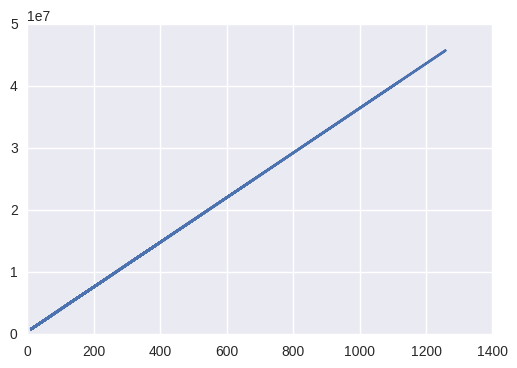

In [15]:
linmodel_total_units = smf.ols(formula = 'gross_income ~ total_units',
                            data = data_small).fit()

linmodel_total_units.summary()
pars = linmodel_total_units.params
pl.plot(data_small.total_units, pars[0] + pars[1]*data_small.total_units)

In [ ]:

#plotting scatterpoint
ax = data_small.plot(x = 'total_units', y = 'gross_income', kind = 'scatter', label='data')

#plotting labels
ax.set_xlabel("Total Units")
ax.set_ylabel("Gross Income (log scale)")
pl.title('Scatterplot of Total Units vs Gross Income (For Manhattan Condos / Coops)', fontsize=14)


#plotting regression line
total_units_plot_range = np.linspace(data_small.total_units.min(), data_small.total_units.max(), 100)
tmp = pd.DataFrame()
tmp['total_units'] = total_units_plot_range

### need to pass .predict() a dataframe!
gross_income_predicted = linmodel_total_units.predict(tmp)
ax.plot(total_units_plot_range, gross_income_predicted, c='r', label='model line')

#setting axis limits
pl.xlim(0, (data_small.total_units.max()+100))
pl.ylim(0, (data_small.gross_income.max()+1000000))

#plotting legend
ax.legend()

## Finals Notes 12-12-16 (GTP)

### SQL Queries

In [2]:
SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
# fill in the query details in facilityQuery: 
# within a single query collect AND GROUP the data by zipcode
facilityQuery = '''
SELECT 
COUNT(*) as count,
zipcodes
FROM nycasthmasdismissals
GROUP BY zipcodes'''

facilityStream = queryCartoDB(facilityQuery, format='JSON')
facilityData   = json.loads(facilityStream.read())
facilityData
facilities     = pd.DataFrame.from_dict(facilityData['rows'])
facilities.columns = ['count', 'ZIPCODE']
facilities.ZIPCODE = facilities.ZIPCODE.astype(str)
facilities.head()

,count,ZIPCODE
0,1699,10461
1,405,11373
2,1698,10451
3,220,11691
4,246,11375


### Time Series Analysis

In [10]:
mta_fare = np.load(PUIdata + "/MTA_Fare.npy")

In [11]:
#23 length dimension represents the ticket types
#600 length dimension represents the stations
#194 length dimension represents the weeks
(mta_fare[0][0])

array([56961, 64703, 68002, 72628, 75866, 72433, 71186, 71498, 73801,
       72517, 74385, 71780, 63174, 66428, 62172, 61027, 56864, 54612,
       55391, 58758, 53615, 55153, 52241, 54237, 56332, 52003, 58227,
       58011, 56841, 54623, 55179, 55156, 61862, 49831, 43851, 44164,
       52134, 53125, 55428, 54826, 56209, 58700, 66411, 62079, 60507,
       64571, 63548, 73987, 69892, 64011, 68611, 66566, 66157, 68076,
       72318, 75898, 85529, 91891, 78091, 76496, 75295, 90936, 89712,
       80988, 78696, 55196, 74775, 69475, 72191, 57003, 68284, 73454,
       73525, 73278, 64865, 69191, 67099, 63017, 67992, 69241, 68079,
       69527, 71535, 66822, 59769, 51868, 54865, 57924, 60498, 58870,
       62098, 60277, 62578, 68971, 71953, 50178, 73127, 76462, 75618,
       71061, 71899, 71825, 67019, 79034, 83422, 76560, 80431, 81958,
       86070, 77442, 86061, 87749, 89065, 85593, 86786, 84939, 82306,
       77443, 74911, 71498, 74978, 71264, 73543, 71579, 70637, 72245,
       11409,     1,

### Clustering

#### k-means

you want to preprocess data so that data doesn't have covariance across features. you can scale the data, or normalize the data, or whiten the data. example: divide columns by their standard deviation if columns are independent. if columns are not necessarily independent (like in a time series!), then need to do the same to rows too. see homework 11 assignment 2 for example.

In [13]:
#run elbow method to determine optimal k for kmeans clustering
def elbow(data, K):
#data is your input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

### Clustering with Time Series

### Spatial Analysis

In [2]:
import shapely
import geopandas as gp

#### Coordinate systems, projections, and transformations

In [3]:
from geopandas import GeoDataFrame
shape_path = PUIdata + "/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [4]:
from fiona.crs import from_epsg
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 

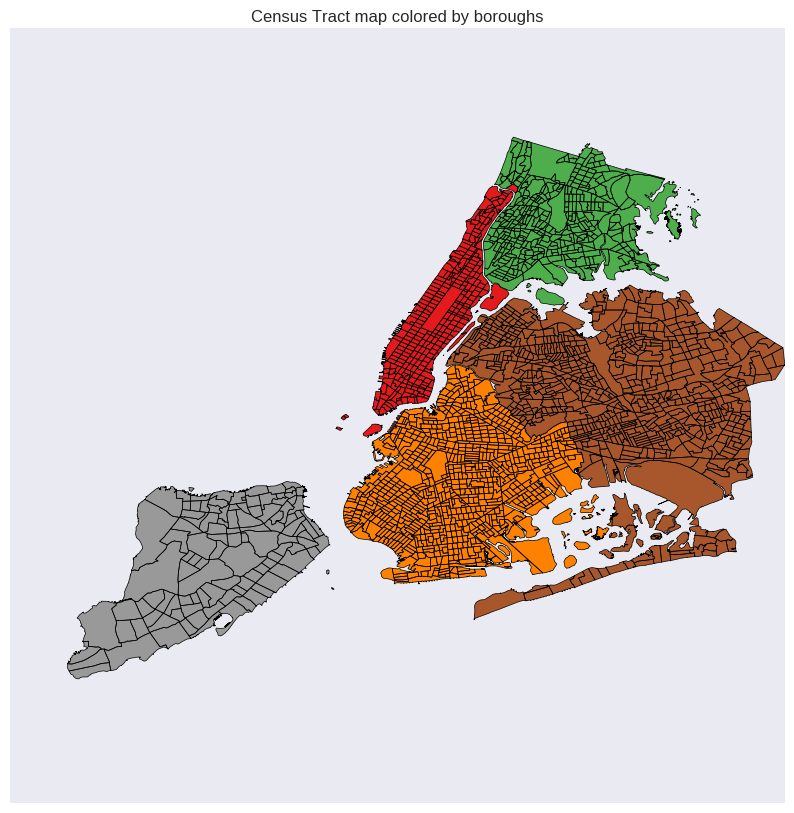

In [5]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

In [7]:
ct_shape.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


### 